# Fashion MNIST classification using PyTorch and CNNs

In this notebook we will try to classify the Fashion MNIST dataset
(https://github.com/zalandoresearch/fashion-mnist) using VGG-like architectures (https://arxiv.org/abs/1409.1556). This notebook is inspired from the MNIST example from PyTorch (https://github.com/pytorch/examples/tree/master/mnist), and introduce tricks to automatically tune and schedule the learning rate for Adam (see this course's slides, https://arxiv.org/abs/1506.01186, and FastAI course for example http://fastai.org).
Some ideas taken from https://www.kaggle.com/bugraokcu/cnn-with-keras


## Fashion MNIST

This 10 class dataset is a drop-in replacement for MNIST with clothes instead of digits. MNIST is arguably overused in the ML community nowadays. It is subtancially harder to classify.

This notebook shows a model reaching **94.17%** accuracy. Which is very good considering Shirt/T-shirt problem (see below).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.94 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

### Introduction


#### Imports

In [2]:
import matplotlib.pyplot as plt # Fo
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

from torchsummary import summary

from IPython.display import clear_output
from IPython.core.debugger import set_trace
import itertools
from itertools import chain
import time, sys
from tqdm import tqdm_notebook as tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# if you're running in google colab
# 1. Comment this
# %reload_ext autoreload
# # reload modules before executing each line
# %autoreload 2
# 2. Uncomment this
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


print('NumPy version: \t\t%s' % np.__version__)
print('PyTorch version: \t%s' % torch.__version__)

import warnings
warnings.filterwarnings('ignore')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
NumPy version: 		1.16.3
PyTorch version: 	1.1.0


#### Constants

In [ ]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook
# If true, save model parameters to GDrive
COLAB = True

# Path to a directory with image dataset and subfolders for training, validation and final testing
if COLAB:
    ROOT_DIR = "/content/gdrive/My Drive/Colab Notebooks/"
else:
    ROOT_DIR = r'../'
DATA_PATH = ROOT_DIR + "data/" # PATH TO THE DATASET
MODELS_PATH = ROOT_DIR + "models/" # PATH TO FOLDER w\ pre-trained models weights

# Number of threads for data loader
NUM_WORKERS = 4

# % of train dataset used for validation
ratio = 0.2

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 28

# Epochs: number of passes over the training data
EPOCH_NUM = 50

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

# Images mean and std channelwise. [0,1] -> [-1,1]
# image_mean = [0.2861]
# image_std  = [0.3529] #[0.3526]
image_mean = [0.5]
image_std  = [0.5]

# Number of classes in the dataset
NUM_CLASSES = 10

In [4]:
print('Root dir: {} \nData dir: {} \nModels dir: {}'.format(ROOT_DIR, DATA_PATH, MODELS_PATH))

Root dir: /content/gdrive/My Drive/Colab Notebooks/ 
Data dir: /content/gdrive/My Drive/Colab Notebooks/data/ 
Models dir: /content/gdrive/My Drive/Colab Notebooks/models/


### Data preprocessing

#### Data loaders
Normalize data and add some data augmentation if needed

In [ ]:
labels = ["T-shirt/top", "Trouser", "Pullover",
                  "Dress", "Coat", "Sandal", "Shirt",
                  "Sneaker", "Bag",  "Ankle boot"]

## Use `norm = False` to count image_mean and image_std
norm = True
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=image_mean, std=image_std)])

complex_transform = transforms.Compose([
                      transforms.RandomAffine(12, translate=(0.05,0.05), 
                                              scale=(0.95,1.05)),
                      transforms.ToTensor(),
                      transforms.Normalize(image_mean, image_std)
                    ])

# Basic datasets used in simple models
train_data = datasets.FashionMNIST(DATA_PATH, train=True, download=True,
                                   transform=transform if norm else transforms.ToTensor())

val_size = int(ratio * len(train_data)) 
train_data, val_data = random_split(train_data, 
                                    [len(train_data) - val_size , val_size])

train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True if norm else False, 
                          num_workers=NUM_WORKERS)

val_loader = DataLoader(val_data, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True if norm else False, 
                        num_workers=NUM_WORKERS)

# Augmented datasets for better results
train_data_aug = datasets.FashionMNIST(DATA_PATH, train=True, download=True,
                                   transform=complex_transform)

val_size = int(ratio * len(train_data_aug)) 
train_data_aug, val_data_aug = random_split(train_data_aug, 
                                    [len(train_data_aug) - val_size , val_size])

train_aug_loader = DataLoader(train_data_aug, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=NUM_WORKERS)

val_aug_loader = DataLoader(val_data_aug, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True, 
                        num_workers=NUM_WORKERS)
# Test dataset used for final evaluation
test_data = datasets.FashionMNIST(DATA_PATH, train=False, download=True,
                                  transform=transform if norm else transforms.ToTensor())

test_loader = DataLoader(test_data, 
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

Count dataset statictics to use for normalization

In [ ]:
if not norm:
    # Count mean for each channel. Assume t.shape == (batch_size, channels, h, w)
    image_mean = torch.stack([torch.mean(t, (0,2,3)) for t, c in train_loader])
    image_mean = torch.mean(image_mean, 0)

    # Count std for each channel. Assume t.shape == (batch_size, channels, h, w)
    image_std = torch.stack([torch.sqrt(
            torch.mean((t - torch.mean(t, (0,2,3), keepdim=True))**2, (0,2,3))) for t, c in train_loader])
    image_std = torch.mean(image_std, 0)
    print(image_mean, image_std)


#### Sanity check

48000 12000 10000


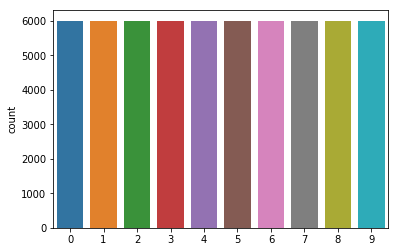

In [7]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

# Check that classes are balanced
import seaborn as sns
g = sns.countplot(train_data.dataset.targets.numpy())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Images')

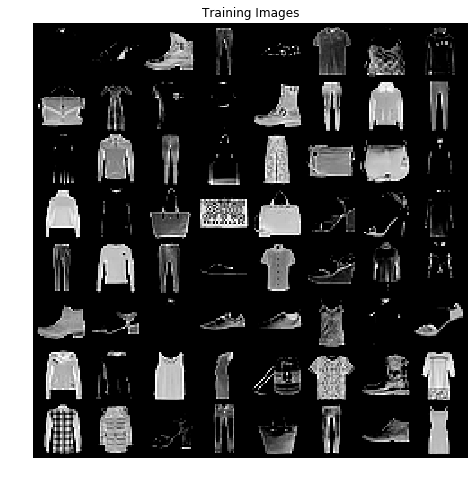

In [8]:
# Let's take a look at our data
X_batch, y_batch = next(iter(train_loader))
imgs = torch.reshape(X_batch[:64], (-1, 1, SIZE_H, SIZE_W))
grid_img = torchvision.utils.make_grid(imgs, nrow=8)

plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0), cmap=matplotlib.cm.get_cmap('gray'))
plt.axis("off")
plt.title("Training Images")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Augmented Training Images')

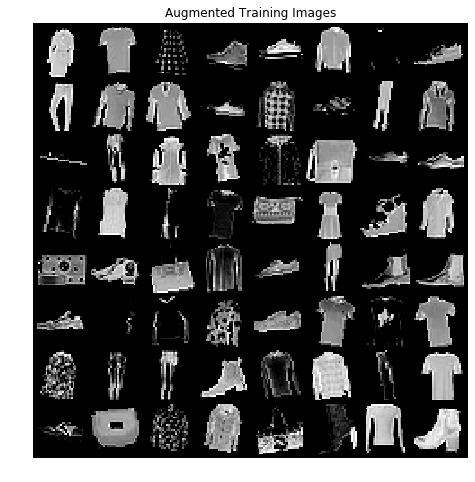

In [9]:
X_batch, y_batch = next(iter(train_aug_loader))
imgs = torch.reshape(X_batch[:64], (-1, 1, SIZE_H, SIZE_W))
grid_img = torchvision.utils.make_grid(imgs, nrow=8)

plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0), cmap=matplotlib.cm.get_cmap('gray'))
plt.axis("off")
plt.title("Augmented Training Images")

### Models


#### SimpleCNN
Used as a baseline

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # _ x 1 x 28 x 28
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            # _ x 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 32 x 14 x 14

            nn.Conv2d(32, 32, 3, padding=1),
            # _ x 32 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            # _ x 32 x 7 x 7    
        )

        self.fc = nn.Sequential(
            # this converts our 2D feature maps to 1D feature vectors
            Flatten(),
            # _ x 32 * 7 * 7 
            nn.Linear(32 * 7 * 7, EMBEDDING_SIZE),
            nn.ReLU()
        )
        
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x

#### BestCNN

In [ ]:
class GoodCNN(nn.Module):
    def __init__(self):
        super(GoodCNN, self).__init__()
        # _ x 1 x 28 x 28
        self.model = nn.Sequential(
            nn.Conv2d(1,64, 5, padding=2),
            # _ x 64 x 28 x 28
            nn.ELU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 64 x 14 x 14
            nn.Dropout2d(0.25),
            
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2),
            # _ x 128 x 14 x 14
            nn.ELU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 128 x 7 x 7
            nn.Dropout2d(0.25),   
            
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2),
            # _ x 256 x 7 x 7
            nn.ELU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 256 x 3 x 3
            nn.Dropout2d(0.25),  
        )

        self.fc = nn.Sequential(
            # this converts our 2D feature maps to 1D feature vectors
            Flatten(),
            # _ x 256 * 3 * 3 
            nn.Linear(256 * 3 * 3, EMBEDDING_SIZE),
            nn.ELU(),
            nn.Dropout(0.5)
        )
        
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x

#### AwesomeCNN

In [ ]:
class AwesomeCNN(nn.Module):
    def __init__(self):
        super(AwesomeCNN, self).__init__()
        # _ x 1 x 28 x 28
        activation = nn.LeakyReLU()
        model = nn.Sequential(
            nn.Conv2d(1,64, 3, padding=1),
            # _ x 64 x 28 x 28
            nn.BatchNorm2d(64),
            activation,
            nn.MaxPool2d(2, stride=2),
            # _ x 64 x 14 x 14
            nn.Dropout2d(0.3),
            
            nn.Conv2d(64, 64, 3, padding=1),
            # _ x 64 x 14 x 14
            nn.BatchNorm2d(64),
            activation,
#             nn.LeakyReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 64 x 7 x 7
            nn.Dropout2d(0.3),   
            
            
            nn.Conv2d(64, 128, 3, padding=1),
            # _ x 128 x 7 x 7
            nn.BatchNorm2d(128),
            activation,
            nn.Dropout2d(0.3),  
        )

        fc = nn.Sequential(
            # this converts our 2D feature maps to 1D feature vectors
            Flatten(),
            # _ x 128 * 7 * 7 
            nn.Linear(128 * 7 * 7, EMBEDDING_SIZE),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            activation,
            nn.Dropout(0.3)
        )
        
        pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
        self.main = nn.Sequential(model, fc, pred)
            
    def forward(self, input):
        output = self.main(input)
        return output

#### Check models

In [13]:
model = SimpleCNN().to(device)
summary(model, (1, SIZE_H, SIZE_W))

model = GoodCNN().to(device)
summary(model, (1, SIZE_H, SIZE_W))

model = AwesomeCNN().to(device)
summary(model, (1, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 256]         401,664
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
       LogSoftmax-11                   [-1, 10]               0
Total params: 413,802
Trainable params: 413,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### Train/test loops and other useful staff

#### Useful functions

In [ ]:
def lr_finder(model, train_batch_generator, opt, lr_start=1e-6, lr_end=1e1, beta=0.99, plot=True):
    """
    Search for optimal learning rate and plot it's landscape
    Used: docs.fast.ai/callbacks.one_cycle.html and
          sgugger.github.io/the-1cycle-policy.html
    """
    loss_history, lr_history= [], []
    i, avg_loss, best_loss = 0, 0., float('inf')
    
    criterion = nn.CrossEntropyLoss()
    
    # Number of iterations for one epoch
    N = len(train_batch_generator)
    # Evenly distribute lr samples on log scale
    q = (lr_end / lr_start) ** (1/N)
    lr = lr_start
    
    optimizer = opt
    optimizer.param_groups[0]['lr'] = lr
    
    for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Searching'):
        i += 1
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute loss, calc grads, perform optimizer step and zero the grads
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        #Smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**i)
        
        #Stop if the loss is exploding
        if i > 1 and smoothed_loss > 4 * best_loss:
            return loss_history, lr_history, best_lr 
          
        #Record the best loss
        if smoothed_loss < best_loss or i==1:
            best_loss = smoothed_loss
            best_lr = lr
            
        #Store the values
        loss_history.append(smoothed_loss)
        lr_history.append(np.log10(lr))
        
        #Do optimizer step
        loss.backward()    

        optimizer.step()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #Update the lr for the next step
        lr *= q
        optimizer.param_groups[0]['lr'] = lr
        
    if plot:
        fig, ax = plt.subplots(1,2)
        ax[0].plot(lr_history,loss_history)
        ax[0].set_xlabel('LR')
        ax[0].set_ylabel('Loss')
        
        ax[1].plot([10 ** x for x in lr_history])
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('LR')
        
    return loss_history, lr_history, best_lr

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_logs(logs):
    """Usage: plot_logs(custom_obj[0])"""
    plt.subplot(1, 2, 1)
    plt.plot(logs['epoch'], logs['val_loss'],'g-', label='validation')
    plt.plot(logs['epoch'], logs['train_loss'], label = 'train')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(logs['epoch'], logs['val_accuracy'],'g-')
    plt.xlabel('Epoch #')
    plt.ylabel('Validation accuracy')

def load_model(model, model_name):
  """Looks for given model_name in MODELS_PATH dir"""
  
  # # Try to load previosly trained model first
  try:
      with open(MODELS_PATH + model_name, 'rb') as f: model = torch.load(f)
      print("Loaded succesfully!")
  except (FileNotFoundError, ) as e:
      print("Pre-trained model not found. Err msg: '{}' ".format(e.args[-1]))

  model.to(device)
  acc, _ = test_model(model, val_loader)  
  print("Model validation accuracy = {:.2f}%".format(acc * 100))
  
  #Print model for debugging
#   summary(model, (1, SIZE_H, SIZE_W))
  
  return model

#### Train/test loop

In [ ]:
def train_model(model, train_batch_generator, val_batch_generator, 
                opt=None, scheduler=None, log_history=None, ckpt_name=None, n_epochs=EPOCH_NUM, 
                annealing=False, verbose=False):
    """Training function
    opt: optimizer, default is SGD
    log_history: to continuie trainig without losing history
    ckpt_name: saves model to disk
    
    """
    if scheduler:
        annealing=True
        
    if log_history:
        logs = log_history
        start_epoch = logs['epoch'][-1]
    else:
        logs = {'epoch': [], 'train_loss': [], 'val_loss': [],
            'val_accuracy': [],'top_val_accuracy' : 0, 'lr': []}
        start_epoch = 0
      
    
    best_model = None
    iteration = 0
    top_val_accuracy = 0
    
    if opt:
        optimizer=opt
    else:
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=0.001, 
                                    weight_decay=0.0001, 
                                    momentum=0.9)
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.NLLLoss(reduction='mean')

    for epoch in range(n_epochs):
        train_loss = []
        val_loss = []
        val_accuracy = []
        start_time = time.time()
        
        
#         if epoch == 25 and annealing:
#             optimizer.param_groups[0]['lr'] *= .1  
#         elif epoch == 40 and annealing:
#             optimizer.param_groups[0]['lr'] *= .1
        
        # TRAIN
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training'):
            # move data to target device
            assert len(X_batch) == len(y_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()    
            optimizer.step()
            train_loss.append(loss.cpu().data.numpy())
            

        # TEST / VALIDATE
        val_accuracy, val_loss = test_model(model, val_batch_generator, criterion=criterion)
        if annealing: scheduler.step(val_loss)
        
           
        clear_output(wait=True)
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        

        train_loss_value = np.mean(train_loss)
        val_accuracy_value = np.mean(val_accuracy) * 100
        
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_value))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy_value))
        
        #Crutch to add parameter to the model
#         model.register_buffer('val_accuracy', torch.Tensor([val_accuracy_value]))
        
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            print('top val accuracy: %.3f' % top_val_accuracy)
            #save checkpoint of the best model to disk
            with open(MODELS_PATH + ckpt_name, 'wb') as f: torch.save(model, f)
        
        logs['epoch'].append(epoch + start_epoch)
        logs['train_loss'].append(train_loss_value)
        logs['val_loss'].append(val_loss)
        logs['val_accuracy'].append(val_accuracy)
        logs['lr'].append(optimizer.param_groups[0]['lr'])

        
        custom_objects = (logs, )
        
    # Load best model found during trainig
    if ckpt_name is not None:
        with open(MODELS_PATH + ckpt_name, 'rb') as f: best_model = torch.load(f)
 
    return best_model, opt, custom_objects


In [ ]:
def test_model(model, test_batch_generator, criterion=None, subset='test', 
               verbose=False, conf_mx=True, errors=False):
    """
    Compute model performance on test/validation dataset
    :criterion: used to compute loss
    """
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc, test_batch_loss = [], []
    y_true, y_predicted = [], []
    incorrect = [] # save all errors here
    for X_batch, y_batch in test_batch_generator:
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute logits
        logits = model(X_batch)
        # compute loss if needed
        if criterion is not None:
            loss = criterion(logits, y_batch)
            test_batch_loss.append(loss.cpu().data.numpy())
        
        # get idx of the max element in a row. 
        y_pred = logits.max(1)[1].data
        y_pred_confidence = logits.max(1)[0].data

        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
        y_true.append(y_batch.cpu().numpy())
        # save for classification_report
        y_predicted.append(y_pred.cpu().numpy())

    test_accuracy = np.mean(test_batch_acc)
    test_loss = np.mean(test_batch_loss)
            
    if verbose:
        print("Results:")
        print("  {} accuracy:\t\t{:.2f} %\n".format(subset, test_accuracy * 100))
        

        #get the predictions for the test data
        y_true = list(chain.from_iterable(y_true))

        y_predicted = list(chain.from_iterable(y_predicted))
        print(sklearn.metrics.classification_report(y_true, y_predicted, 
                                                    target_names=labels))

        #get the indices to be plotted
        incorrects = np.nonzero([x != y for x,y in zip(y_predicted, y_true)])[0] 
        
        if errors:
          plt.figure(figsize=(8,8))
          for i, incorrect in enumerate(incorrects[0:9]):
              plt.subplot(3,3,i+1)

              plt.imshow(test_batch_generator.dataset.data[incorrect], cmap='gray')
              plt.title("Pred: {}, Tr: {}".format(labels[y_predicted[incorrect]], 
                                                          labels[y_true[incorrect]]))
              plt.tight_layout()
              plt.axis('off')
        
        if conf_mx:
          # compute the confusion matrix
          confusion_mtx = sklearn.metrics.confusion_matrix(y_true, y_predicted) 
          # plot the confusion matrix
          plot_confusion_matrix(confusion_mtx, classes = labels) 


        if test_accuracy * 100 > 90:
            print("Amazing!")
        elif test_accuracy * 100 > 70:
            print("Good!")
        else:
            print("We need more magic! Follow instructons below")
    return test_accuracy, test_loss

### Part 1

Обучить сеть, которая покажет >= 0.94 test accuracy.


#### Baseline model

Simplest CNN possible. No data augmentation, no batchnorm, no dropout and SGD as optimizer without LR annealing

In [359]:
model = SimpleCNN()
model_name = 'simple_cnn'

# Load pre-trained models weights
# model = load_model(model, model_name)

lr = 3e-4
bm_baseline, optim, custom_obj = train_model(model, train_loader, val_loader, 
                                             ckpt_name=model_name, 
                                             n_epochs=30)
plot_logs(custom_obj[0])

Epoch 10 of 10 took 8.867s
  training loss (in-iteration): 	0.265876
  validation accuracy: 			89.75 %
top val accuracy: 89.749


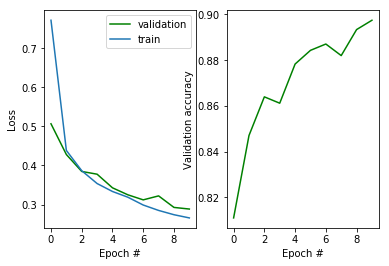

Results:
  test accuracy:		88.84 %

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.75      0.81      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.79      0.87      0.83      1000
       Dress       0.89      0.89      0.89      1000
        Coat       0.83      0.81      0.82      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.66      0.73      0.69      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Good!


(0.88837890625, nan)

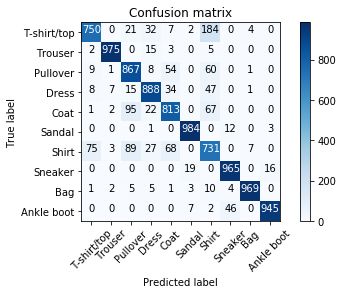

In [362]:
# Fimal test
test_model(bm_baseline, test_loader, verbose=True, conf_mx=False)

As can be seen on the learning plot's --  model is easily overfitted (difference between train and validation losses increases). To address that problem I trained 2 more complex models (see below).

#### Top model
Better achitecture with dropout between convolutions and some batchnormalization before activation layers. Adam optimizer used instead of SGD. Weight decay helps to regularize model during long training. Scheduler decreases LR to get closer to the optima.

Epoch 200 of 200 took 11.492s
  training loss (in-iteration): 	0.122999
  validation accuracy: 			93.27 %


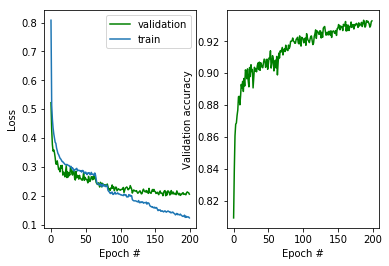

In [22]:
model = GoodCNN()
model_name = 'good_cnn'

# Load pre-trained models weights if needed
# model = load_model(model, model_name)
lr = 3e-3
opt = torch.optim.Adam(model.parameters(), 
                       lr=lr, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=1e-5) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=10, 
                                           min_lr=1e-5)

bm_top, optim, custom_obj = train_model(model, train_aug_loader, val_aug_loader, opt,
                                    scheduler=scheduler, ckpt_name=model_name, 
                                    n_epochs=200, verbose=False, annealing=True)

plot_logs(custom_obj[0])

Results:
  test accuracy:		93.70 %

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.88      0.89      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.92      0.91      1000
       Dress       0.94      0.95      0.94      1000
        Coat       0.89      0.92      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.83      0.79      0.81      1000
     Sneaker       0.97      0.98      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Amazing!


(0.93701171875, nan)

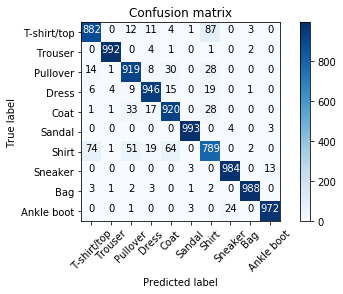

In [23]:
# Fimal test
test_model(bm_top, test_loader, verbose=False, conf_mx=False)

Good enough, but still can be improved. "Steps" on training loss curve happen each time when  LR is decreased by the optimizer. 
Most difficult class to predict: **Shirt** it's confused with T-shirt and Coat very often.

#### Top top model
Model which scores 94%+ accuracy if trained properly. Has more conv layers than previous model, more regularization using dropout (to prevent overfitting during long training).

Epoch 300 of 300 took 10.827s
  training loss (in-iteration): 	0.120484
  validation accuracy: 			93.41 %


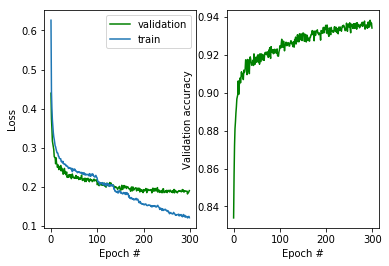

In [24]:
model = AwesomeCNN()
model_name = 'awesome_cnn'

# Load pre-trained models weights
# model = load_model(model, model_name)

lr = 3e-3
opt = torch.optim.Adam(model.parameters(), 
                       lr=lr, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=1e-5) ## !!!

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=15, ## !!!
                                           min_lr=1e-5)


bm, optim, custom_obj = train_model(model, train_aug_loader, val_aug_loader, opt,
                                    scheduler=scheduler, ckpt_name=model_name, 
                                    n_epochs=300, verbose=False, annealing=True)
plot_logs(custom_obj[0])

Results:
  test accuracy:		94.15 %

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.90      0.90      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.91      0.93      0.92      1000
       Dress       0.94      0.95      0.94      1000
        Coat       0.91      0.93      0.92      1000
      Sandal       1.00      1.00      1.00      1000
       Shirt       0.84      0.81      0.83      1000
     Sneaker       0.97      0.99      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.99      0.97      0.98      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Amazing!


(0.94150390625, nan)

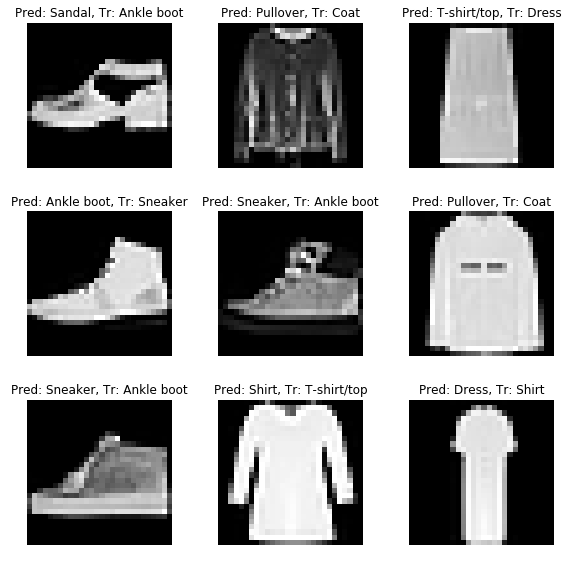

In [28]:
# Fimal test
test_model(bm, test_loader, verbose=True, conf_mx=False)

### Part 2
**Overfitting**

Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).

Overfitt goodCNN. SGD as optimizer, no anealing. Same learning proccess for all models, except changing embedding size of the FC layer. 

In [40]:
log = []
for EMBEDDING_SIZE in [256, 512, 1024, 2048]:
    model = SimpleCNN()
    model_name = 'simple_cnn_{}'.format(EMBEDDING_SIZE)

    lr = 3e-4

    _, _, custom_obj = train_model(model, train_loader, val_loader, ckpt_name=model_name, n_epochs=50, verbose=False)
    log.append(custom_obj[0])
    

Epoch 30 of 30 took 9.568s
  training loss (in-iteration): 	0.281462
  validation accuracy: 			90.32 %
top val accuracy: 90.323


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GoodCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

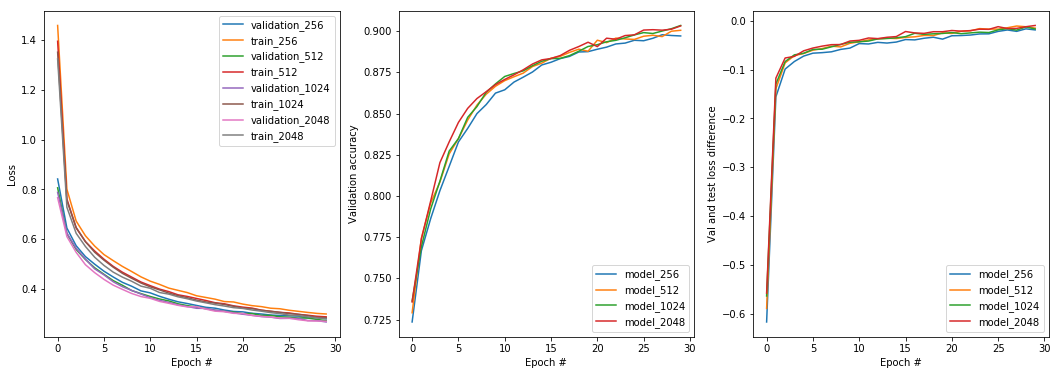

In [41]:
size = [256, 512, 1024, 2048]
plt.figure(num=None, figsize=(18, 6), facecolor='w', edgecolor='k')
for i, logs in enumerate(log):
    plt.subplot(1, 3, 1)
    plt.plot(logs['epoch'], logs['val_loss'], label='validation_{}'.format(size[i]))
    plt.plot(logs['epoch'], logs['train_loss'], label = 'train_{}'.format(size[i]))
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    # fig, ax = plt.subplots(2, 2)
    plt.plot(logs['epoch'], logs['val_accuracy'], label='model_{}'.format(size[i]))
    plt.xlabel('Epoch #')
    plt.ylabel('Validation accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    diff = [i - j for i, j in zip(logs['val_loss'], logs['train_loss'])]
    plt.plot(logs['epoch'], diff, label='model_{}'.format(size[i]))
    plt.xlabel('Epoch #')
    plt.ylabel('Val and test loss difference')
    plt.legend()

На третьем графике видно, как ошибка на валидации сначала уменьшается и приближается к ошибке на обучающей выборке, но в какой-то момент начинает расти -- это и есть переобучение (сеть запоминает данные вместо выявления закономерностей и начинает сильнее ошибаться на тесте). 

## Garbage

**let's look at the activation maps**

torch.Size([1, 28, 28])


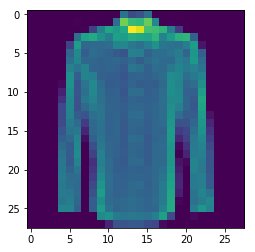

In [261]:
# test_img, label = train_data[23]
# print(test_img.shape)
# plt.imshow(test_img[0].numpy(), cmap='viridis', interpolation='none')

**Fine-tunning**

Используем предобученный ResNet и обучаем лишь полносвязный слой, оставляя нетронутым все остальные.

In [ ]:
resnet18 = models.resnet18(pretrained=True)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False